# Examination of GSE69244

Tong Shu Li

Examine drift and try to find Gene Ontology groupings which drift.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys

from collections import defaultdict
from functools import partial

In [2]:
sys.path.append("..")

In [3]:
from src.plots import plot_drift
from src.plots import plot_p_val_heatmap

from src.stats import p_val_pairs

from src.gene_ont import load_annotations
from src.gene_ont import parse_go_defn
from src.gene_ont import parse_go_links
from src.gene_ont import group_genes
from src.gene_ont import filter_go

from src.util import union

In [4]:
%matplotlib inline

---

## Read the pre-normalized drift data

In [5]:
data = pd.read_csv("../data/GSE69244/norm_avg_drift.tsv", sep = '\t')

In [6]:
data.shape

(45690, 10)

In [7]:
data.head()

,months_old,drug_given,gene_id,mgi_id,gene_count,log_count,ref_log_count,ref_sample,drift,sample_name
0,3,vehicle,0610007P14Rik,MGI:1915571,342.5,5.836272,5.720312,1,-0.034916,young
1,3,vehicle,0610009B22Rik,MGI:1913300,154.0,5.036953,4.836282,1,0.049794,young
2,3,vehicle,0610009L18Rik,MGI:1914088,23.5,3.157000,2.944439,1,0.061685,young
3,3,vehicle,0610009O20Rik,MGI:1914089,551.0,6.311735,6.214608,1,-0.053750,young
4,3,vehicle,0610010F05Rik,MGI:1918925,694.0,6.542472,6.545350,1,-0.153754,young


## Drift for all samples

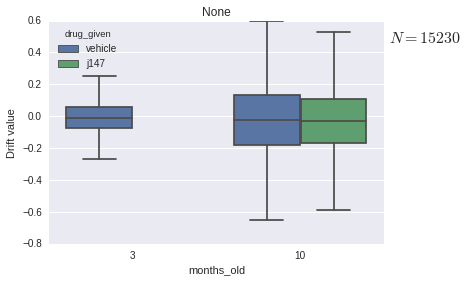

In [8]:
plot_drift(
    "box", data, "months_old", "drift", "gene_id", groupby = "drug_given"
)

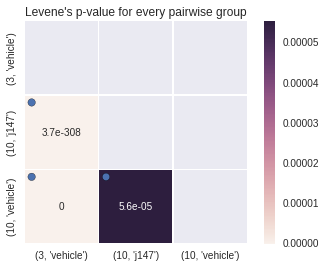

In [9]:
plot_p_val_heatmap(
    data, ["months_old", "drug_given"], "drift", circles = True
)

Drift in this sample is significant between the groups, but the overall drift value is quite small (0.6 at most).

# Drift grouped by GO annotations

## Read the mouse GO annotations

In [10]:
go_defn = parse_go_defn("../data/gene_ontology/go.obo")

In [11]:
go_defn.head()

,go_id,go_name,namespace,obsolete
0,GO:0000001,mitochondrion inheritance,biological_process,False
1,GO:0000002,mitochondrial genome maintenance,biological_process,False
2,GO:0000003,reproduction,biological_process,False
3,GO:0000005,obsolete ribosomal chaperone activity,molecular_function,True
4,GO:0000006,high-affinity zinc uptake transmembrane transp...,molecular_function,False


In [12]:
mouse_go = load_annotations("../data/gene_ontology/gene_association.mgi")

In [13]:
mouse_go.shape

(369000, 16)

In [14]:
mouse_go.head()

,database_id,db_obj_symbol,qualifier,go_id,db_ref,evidence,with_from,aspect,db_obj_name,db_obj_syn,db_obj_type,taxon,date,assigned_by,annot_ext,gene_prod_id
0,MGI:1918911,0610005C13Rik,NaN,GO:0003674,MGI:MGI:2156816|GO_REF:0000015,ND,NaN,F,RIKEN cDNA 0610005C13 gene,NaN,gene,taxon:10090,20100209,MGI,NaN,NaN
1,MGI:1918911,0610005C13Rik,NaN,GO:0005575,MGI:MGI:2156816|GO_REF:0000015,ND,NaN,C,RIKEN cDNA 0610005C13 gene,NaN,gene,taxon:10090,20100209,MGI,NaN,NaN
2,MGI:1918911,0610005C13Rik,NaN,GO:0008150,MGI:MGI:2156816|GO_REF:0000015,ND,NaN,P,RIKEN cDNA 0610005C13 gene,NaN,gene,taxon:10090,20100209,MGI,NaN,NaN
3,MGI:1923503,0610006L08Rik,NaN,GO:0003674,MGI:MGI:2156816|GO_REF:0000015,ND,NaN,F,RIKEN cDNA 0610006L08 gene,NaN,gene,taxon:10090,20120430,MGI,NaN,NaN
4,MGI:1923503,0610006L08Rik,NaN,GO:0005575,MGI:MGI:2156816|GO_REF:0000015,ND,NaN,C,RIKEN cDNA 0610006L08 gene,NaN,gene,taxon:10090,20120430,MGI,NaN,NaN


In [15]:
mouse_go["go_id"].nunique()

16940

In [16]:
mouse_go["database_id"].nunique()

24215

## Read the Gene Ontology hierarchy

In [17]:
fname = "../data/gene_ontology/go.obo"
children = parse_go_links(fname)

---

## Genes annotated with each GO term

In [18]:
# save the genes for each annotated go term
annots = defaultdict(
    set,
    {
        go_term: set(df["database_id"])
        for go_term, df in mouse_go.groupby("go_id")
    }
)

## Genes associated with each GO term (according to the hierarchy)

In [19]:
go_groups = group_genes(children, annots, ["is_a", "part_of"])

### Some statistics:

In [20]:
info = pd.DataFrame(
    [(term, len(genes)) for term, genes in go_groups.items()],
    columns = ["go_id", "num_genes"]
).sort_values("num_genes", ascending = False).reset_index(drop = True)

info = pd.merge(info, go_defn, how = "inner", on = "go_id")

In [21]:
info.shape

(42514, 5)

In [22]:
info.head()

,go_id,num_genes,go_name,namespace,obsolete
0,GO:0008150,23775,biological_process,biological_process,False
1,GO:0005575,23483,cellular_component,cellular_component,False
2,GO:0003674,23068,molecular_function,molecular_function,False
3,GO:0005623,14976,cell,cellular_component,False
4,GO:0044464,14963,cell part,cellular_component,False


In [23]:
all(~info["obsolete"])

True

In [24]:
(info["num_genes"] == 0).sum()

21526

In [25]:
(info["num_genes"] > 0).sum()

20988

In [26]:
(info["num_genes"] >= 10).sum()

8023

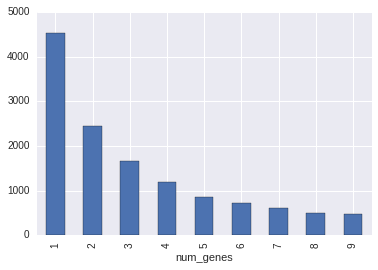

In [27]:
info.query("0 < num_genes < 10").groupby("num_genes").size().plot(kind = "bar")

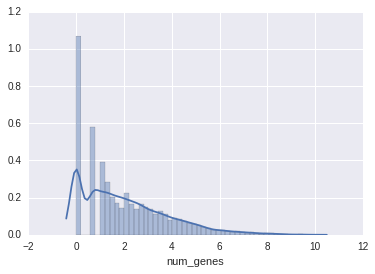

In [28]:
sns.distplot(np.log(info.query("num_genes > 0")["num_genes"]))

## Drop GO terms with no annotations

In [29]:
info = info.query("num_genes > 0")

## Check which annotated genes are in the RNA-seq dataset

In [30]:
good_genes = set(data["mgi_id"])

info["num_in_data"] = info["go_id"].map(
    lambda v: len(good_genes & go_groups[v])
)

info = info.sort_values("num_in_data", ascending = False).reset_index(drop = True)
info["frac_present"] = info["num_in_data"] / info["num_genes"]

In [31]:
info.shape

(20988, 7)

In [32]:
info.head()

,go_id,num_genes,go_name,namespace,obsolete,num_in_data,frac_present
0,GO:0005575,23483,cellular_component,cellular_component,False,14571,0.620491
1,GO:0008150,23775,biological_process,biological_process,False,14535,0.611356
2,GO:0003674,23068,molecular_function,molecular_function,False,14355,0.622291
3,GO:0005623,14976,cell,cellular_component,False,11766,0.785657
4,GO:0044464,14963,cell part,cellular_component,False,11763,0.786139


In [33]:
info["num_in_data"].describe()

count    20988.000000
mean        67.883267
std        435.361136
min          0.000000
25%          1.000000
50%          4.000000
75%         18.000000
max      14571.000000
Name: num_in_data, dtype: float64

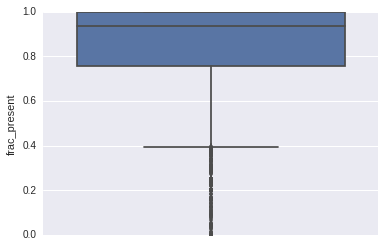

In [34]:
sns.boxplot(y = info["frac_present"])

In [35]:
(info["num_in_data"] >= 10).sum()

7308

In [36]:
info = info.query("num_in_data >= 10")

With the GO hierarchy considered, we see that we now have 7308 testable GO terms with >= 10 genes, instead of the previous 3329.

## Hypothesis testing

## Significance checking function

In [37]:
def signif(go_term, df, go_groups, groupby, drift_col, conditions):
    """Check for significant drift.
    
    For a subset of genes specified by the GO term, calculates the
    p-values when grouped together by the groupby. Then checks that
    all p values of the condition pairs are below the significance
    threshold.
    
    Conditions = dict(key: direction)
    where key = pair of groups, direction = boolean of whether the variance
    of the left group is larger
    """
    res = filter_go([go_term], go_groups, df, "mgi_id")
    
    p_vals = p_val_pairs(res, groupby, drift_col)
    
    threshold = 0.05
    for pair in conditions:
        assert pair in p_vals, "{} not in p-val pairs".format(pair)
        
    return all(
        p_vals[i][0] < threshold and p_vals[i][1] == direction
        for i, direction in conditions.items()
    )

## GO groups which increase in drift in vehicle

In [38]:
drift_ctrl = partial(
    signif, df = data.query("drug_given == 'vehicle'"),
    go_groups = go_groups, groupby = "months_old",
    drift_col = "drift",
    conditions = {(3, 10): False}
)

info["d_ctrl"] = info["go_id"].map(drift_ctrl)

In [39]:
info.head()

,go_id,num_genes,go_name,namespace,obsolete,num_in_data,frac_present,d_ctrl
0,GO:0005575,23483,cellular_component,cellular_component,False,14571,0.620491,True
1,GO:0008150,23775,biological_process,biological_process,False,14535,0.611356,True
2,GO:0003674,23068,molecular_function,molecular_function,False,14355,0.622291,True
3,GO:0005623,14976,cell,cellular_component,False,11766,0.785657,True
4,GO:0044464,14963,cell part,cellular_component,False,11763,0.786139,True


In [40]:
info["d_ctrl"].value_counts()

True     4872
False    2436
Name: d_ctrl, dtype: int64

In [41]:
info.query("d_ctrl")["num_in_data"].describe()

count     4872.000000
mean       273.497947
std        872.486639
min         10.000000
25%         27.000000
50%         59.500000
75%        156.250000
max      14571.000000
Name: num_in_data, dtype: float64

## GO groups which decrease in drift when given J147

In [42]:
drift_old = partial(
    signif, df = data.query("months_old == 10"),
    go_groups = go_groups, groupby = "drug_given",
    drift_col = "drift",
    conditions = {("j147", "vehicle"): False}
)

info["reduc_j147"] = info["go_id"].map(drift_old)

In [43]:
info["reduc_j147"].value_counts()

False    7213
True       95
Name: reduc_j147, dtype: int64

In [44]:
info.groupby(["d_ctrl", "reduc_j147"]).size()

d_ctrl  reduc_j147
False   False         2436
True    False         4777
        True            95
dtype: int64

In [45]:
info.query("d_ctrl & reduc_j147")

,go_id,num_genes,go_name,namespace,obsolete,num_in_data,frac_present,d_ctrl,reduc_j147
0,GO:0005575,23483,cellular_component,cellular_component,False,14571,0.620491,True,True
1,GO:0008150,23775,biological_process,biological_process,False,14535,0.611356,True,True
2,GO:0003674,23068,molecular_function,molecular_function,False,14355,0.622291,True,True
3,GO:0005623,14976,cell,cellular_component,False,11766,0.785657,True,True
4,GO:0044464,14963,cell part,cellular_component,False,11763,0.786139,True,True
5,GO:0005622,12954,intracellular,cellular_component,False,10730,0.828316,True,True
6,GO:0044424,12815,intracellular part,cellular_component,False,10627,0.829263,True,True
7,GO:0009987,14394,cellular process,biological_process,False,10502,0.729610,True,True
8,GO:0043226,12129,organelle,cellular_component,False,10118,0.834199,True,True
9,GO:0005488,12328,binding,molecular_function,False,9685,0.785610,True,True


With the GO hierarchy in consideration, we now see 95 GO terms with >= 10 genes which drift in control but are reduced when given J147.

## Checking our results

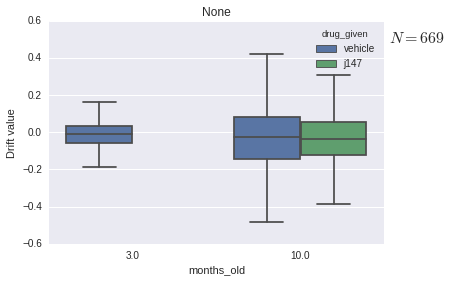

In [46]:
term = "GO:1990234" # transferase complex

res = filter_go([term], go_groups, data, "mgi_id")
plot_drift(
    "box", res, "months_old", "drift", "mgi_id",
    groupby = "drug_given"
)

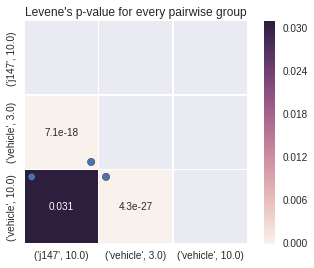

In [47]:
plot_p_val_heatmap(res, ["drug_given", "months_old"], "drift", circles = True)